# Libraries

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import words,stopwords
from nltk.tokenize import word_tokenize

nltk.download('words')
nltk.download('punkt')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.cm as cm

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Importing cleaned datasets

In [ ]:
# Load cleaned dataset
df = pd.read_csv(r"/content/final_cleaned_translation_data.csv")

# Display the first 5 entries of the DataFrame
df.head(5)

,Unnamed: 0,clean_text,translated_text,tokenize_text,Mood
0,0,innovation officially open click learn tech ja...,innovation officially open click learn tech ja...,"['innovation', 'officially', 'open', 'click', ...",0
1,1,open asia pacific seoul region aresysadmin,open asia pacific seoul region aresysadmin,"['open', 'asia', 'pacific', 'seoul', 'region',...",0
2,2,beginners guide scaling million users amazons ...,beginners guide scaling million users amazons ...,"['beginners', 'guide', 'scaling', 'million', '...",0
3,3,bridging azure environments aresysadmin,bridging azure environments aresysadmin,"['bridging', 'azure', 'environments', 'aresysa...",0
4,4,elasticsearch service elasticbeanstalk laravel...,elasticsearch service elasticbeanstalk laravel...,"['elasticsearch', 'service', 'elasticbeanstalk...",0


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Filter and check rows where 'translated_text' is an empty list
df_empty = df[df['translated_text'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

# Display the filtered rows
print(df_empty)

# Preprocessing functions
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

df['translated_text'] = df['translated_text'].apply(preprocess_text)

# Remove rows with empty strings or strings containing only '[]'
df = df[df['translated_text'].str.strip() != '']
df = df[df['translated_text'] != '[]']

Empty DataFrame
Columns: [Unnamed: 0, clean_text, translated_text, tokenize_text, Mood]
Index: []


In [ ]:
df['Mood'].value_counts()

,count
Mood,
0,63917
1,26446
2,5275


<ipython-input-6-ca2ddeeb0ee1>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(mood_counts))


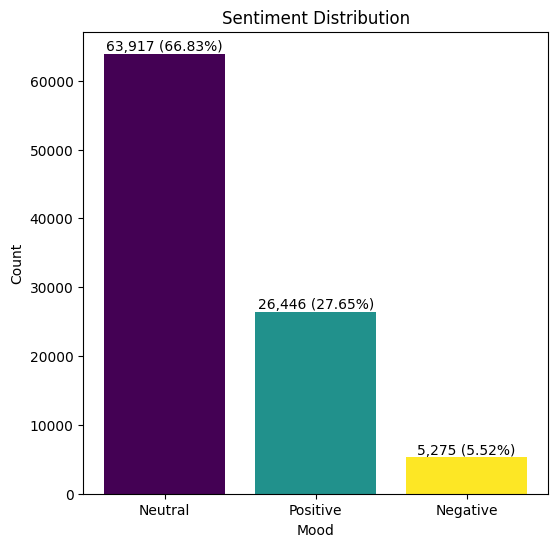

In [ ]:
# Count the occurrences of each mood
mood_counts = df['Mood'].value_counts().sort_index()

# Map the mood numbers to labels
mood_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
mood_counts.index = mood_counts.index.map(mood_labels)

# Define colors using 'viridis' colormap
cmap = cm.get_cmap('viridis', len(mood_counts))
colors = [cmap(i) for i in range(len(mood_counts))]

# Calculate percentages
total_count = mood_counts.sum()
mood_percentages = (mood_counts / total_count) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Mood')
plt.ylabel('Count')

# Add value annotations on the bars with comma formatting and percentages
for bar, percentage in zip(bars, mood_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.show()

### Splitting the data to training data and test data
- Set stratify=y in train_test_split, it ensures that the class distribution in the training and testing sets is the same as in the original dataset. For example, if your original dataset has 66% 'Neutral', 27% 'Positive', and 15% 'Negative' samples, the training and testing sets will also have approximately the same proportions of these classes.  This helps to ensure that the model is trained and tested on representative samples of the data, avoiding biases that could arise from having different class distributions in the training and testing sets. Avoiding biases means preventing the situation where the model might perform well on some classes but poorly on others due to imbalanced representation in the training or testing data.

# Data Modelling for imbalanced dataset

In [ ]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['translated_text'])
y = df['Mood']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Display shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (76510, 29343)
X_test shape: (19128, 29343)
y_train shape: (76510,)
y_test shape: (19128,)


###  Model training, validation and evaluation procedures


Random Forest Results:
Accuracy: 0.9460
Precision: 0.9463
Recall: 0.9460
F1 Score: 0.9445
ROC AUC: 0.9839
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12784
           1       0.95      0.91      0.93      5289
           2       0.96      0.69      0.81      1055

    accuracy                           0.95     19128
   macro avg       0.95      0.86      0.90     19128
weighted avg       0.95      0.95      0.94     19128

Confusion Matrix:
[[12576   188    20]
 [  491  4788    10]
 [  257    67   731]]


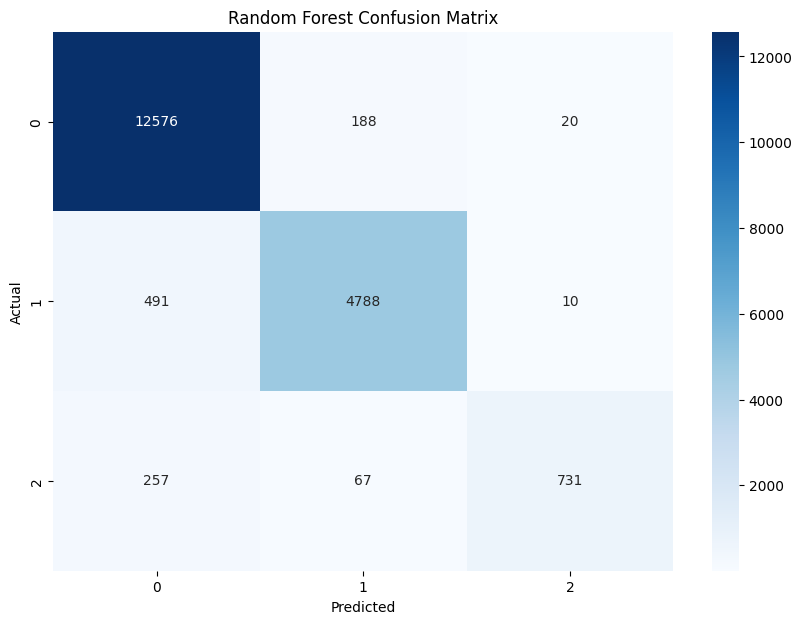


Logistic Regression Results:
Accuracy: 0.9135
Precision: 0.9142
Recall: 0.9135
F1 Score: 0.9096
ROC AUC: 0.9718
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12784
           1       0.93      0.84      0.88      5289
           2       0.91      0.53      0.67      1055

    accuracy                           0.91     19128
   macro avg       0.92      0.78      0.83     19128
weighted avg       0.91      0.91      0.91     19128

Confusion Matrix:
[[12466   286    32]
 [  820  4449    20]
 [  433    63   559]]


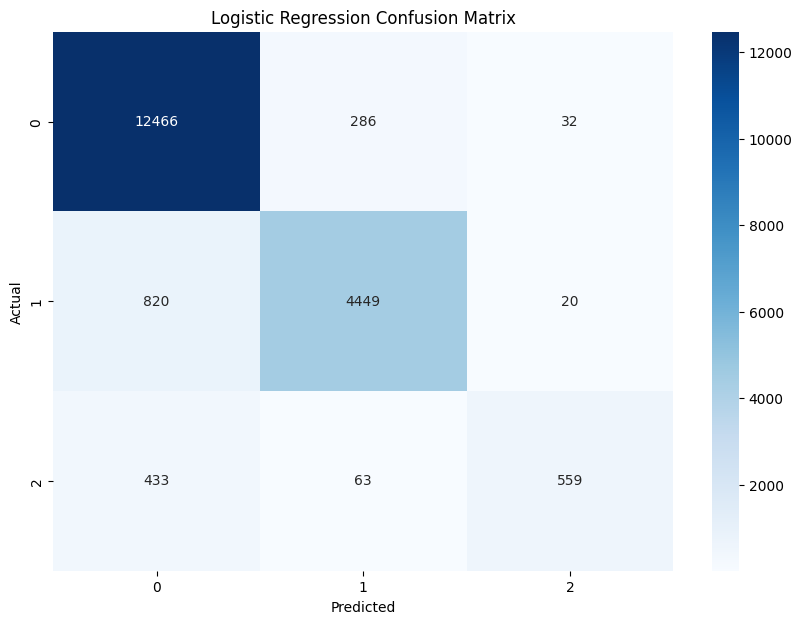

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:01:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy: 0.8892
Precision: 0.8939
Recall: 0.8892
F1 Score: 0.8824
ROC AUC: 0.9524
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     12784
           1       0.94      0.75      0.83      5289
           2       0.92      0.46      0.61      1055

    accuracy                           0.89     19128
   macro avg       0.91      0.73      0.79     19128
weighted avg       0.89      0.89      0.88     19128

Confusion Matrix:
[[12547   213    24]
 [ 1290  3980    19]
 [  519    54   482]]


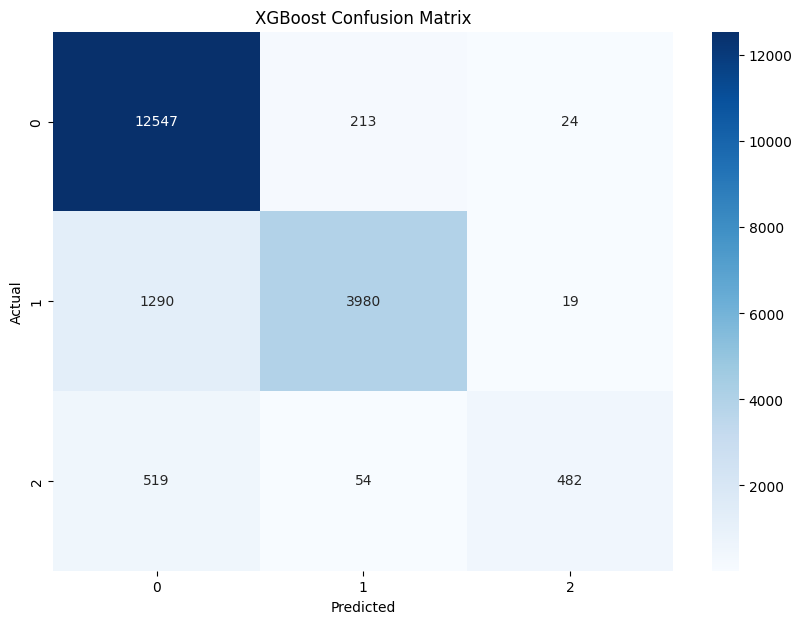

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


 -It is evident that the recall for the minority class (negative) is significantly lower across all models:

-**Random Forest**: Recall for class 2 is 0.69, which is notably lower compared to class 0 (0.98) and class 1 (0.91).

-**Logistic Regression**: Recall for class 2 is 0.53, which is much lower compared to class 0 (0.98) and class 1 (0.84).

-**XGBoost**: Recall for class 2 is 0.46, again lower compared to class 0 (0.98) and class 1 (0.75)




-This could be due to class imbalance. To overcome this, SMOTE (Synthetic Minority Over-sampling Technique) is a good solution. SMOTE generates synthetic samples for the minority class, balancing the dataset and improving recall for the minority class.